# Predicitng no-show patients at a Dental Practice

## Introduction

### Goal
To document steps used to create a machine learning algorithm that predicts patient attendance.

### Steps

1) Data Processing

2) Features Engineering

3) Building ML model

4) Visualizing model output



## 1) Data Processing Sample


Read in data from the visits and cancelations files. Cancelations are a subset of the visits file. The cancelations file has additional data about each canceled appointment. 

In [4]:
###packages
import dask.dataframe as dd
import numpy as np
import glob, os, platform


###set input and output directories
input_dir = "/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/raw_data/"
output_dir = "/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/"

###read 
visits = dd.read_csv(input_dir + '*visits_all_source_data*.csv', parse_dates=['AppointmentDate'])
cancels = dd.read_csv(input_dir + "*cancellations*", parse_dates=['AppointmentDate','RescheduledDate'])
cancels['target'] = "cancel"

In [5]:
visits.columns

Index(['AppointmentDate', 'Status', 'Provider', 'Guarantor', 'GuarantorEmail',
       'Patient', 'PatientEmail', 'NP', 'Procedures', 'VisitType', 'PatientId',
       'PatientPhone1', 'PatientPhone2', 'PatientPhone3', 'GuarantorPhone1',
       'GuarantorPhone2', 'GuarantorPhone3', 'SubscriberID', 'DiscountPlan'],
      dtype='object')

In [6]:
cancels.columns

Index(['AppointmentDate', 'Provider', 'Guarantor', 'GuarantorPhone', 'Patient',
       'PatientPhones', 'Age', 'NP', 'Procedures', 'VisitType', 'Scheduled$',
       'RescheduledDate', 'target'],
      dtype='object')

In [7]:
##merge visits and cancels
visitspluscancels = dd.merge(visits,cancels[['Patient',
                                             'AppointmentDate',
                                             'Provider',
                                             'Procedures',
                                             'Guarantor',
                                             'VisitType',
                                             'NP',
                                             'Age',
                                             'target',
                                             'Scheduled$',
                                             'RescheduledDate']],
                             on=['Patient',
                                      'AppointmentDate',
                                      'Provider',
                                      'Procedures',
                                      'Guarantor',
                                      'VisitType',
                                      'NP'], 
                             how='left')

#save files out
visitspluscancels.to_csv(output_dir + "visitspluscancels - 2018.*.csv",index=False)

['/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/visitspluscancels - 2018.00.csv',
 '/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/visitspluscancels - 2018.01.csv',
 '/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/visitspluscancels - 2018.02.csv',
 '/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/visitspluscancels - 2018.03.csv',
 '/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/visitspluscancels - 2018.04.csv',
 '/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/visitspluscancels - 2018.05.csv',
 '/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/codes/A_insight/intermediates/visitspluscancels - 2018.06.csv',

In [8]:
##display output, scrubbed of patient info for hipaa 
visitspluscancels[["AppointmentDate", "PatientId", "Status", "Procedures", "VisitType", "SubscriberID", "NP", "Age", "Scheduled$", "target"]].head()


,AppointmentDate,PatientId,Status,Procedures,VisitType,SubscriberID,NP,Age,Scheduled$,target
0,2018-04-03 10:30:00,2124,Completed,D2392,Restorative,NaN,No,NaN,NaN,NaN
1,2018-04-03 14:00:00,9810,Completed,D0150,Restorative,NaN,No,NaN,NaN,NaN
2,2018-04-04 10:00:00,10048,Completed,"D2331, D2332",Restorative,NaN,No,NaN,NaN,NaN
3,2018-04-10 11:00:00,10220,Completed,"D2391, D2394, D2391, D2393",Restorative,NaN,No,NaN,NaN,NaN
4,2018-04-11 11:30:00,10261,Completed,"D7140, D0140, D0220, D0230",Restorative,NaN,Yes,NaN,NaN,NaN


## 2) Feature Engineering

In [1]:
import pandas as pd
#read in initial data and display 
final_input = "/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/intermediary_output/"
visits= pd.read_csv(final_input+"visitspluscancelsplusnoshowsplusnewpatients -  2018.csv")
visits=visits[visits["Status"]!="Completed (Unknown)"]


### Manual Feature Creation Examples

In [6]:
## Manual feature creation
##age of the patient in months, with legacy patients slightly older by 1 month
visits["loyalty"] = ((pd.to_datetime(visits['AppointmentDate'], format='%Y-%m-%d %H:%M:%S').dt.year -
                     visits.newpatientfile.astype(str).str[:4].astype(int)) *12 +
                     (pd.to_datetime(visits['AppointmentDate'], format='%Y-%m-%d %H:%M:%S').dt.month - 
                      visits.newpatientfile.astype(str).str[5:7].astype(int)))
visits["loyalty"].head()

0    27
1    13
2    24
3    20
4    24
Name: loyalty, dtype: int64

In [12]:
##number of producedures
visits["nProcedures"] = visits.Procedures.str.split().str.len() ##setting up numbers of procedures
visits["noshow"] = pd.get_dummies(visits["Status"]).Broken #Target
visits["newbie"] = pd.get_dummies(visits.NP).Yes #are they new? 1 is Yes

In [2]:
##save the data set
full_dataset = visits

full_dataset.to_pickle(input_dir + "preFT2018.pkl")

NameError: name 'visits' is not defined

### Automatic Feature Creation using featuretools

In [32]:
import featuretools as ft
import featuretools.variable_types as vtypes
import pandas as pd

input_dir = "/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/intermediary_output/"

#import and load data
full_dataset = pd.read_pickle(input_dir + "preFT2018.pkl")
#use below code at experimentation stage to build new features on a small dataset.
#full_dataset = full_dataset.iloc[:5,:]

full_dataset.AppointmentDate = (pd.to_datetime(full_dataset.AppointmentDate) + 
                                (pd.Timedelta(days = 1) - pd.Timedelta(seconds = 1)) * (full_dataset.noshow))



variable_types = {'PatientId': vtypes.Numeric, 'newbie':vtypes.Boolean,'insuranceDummy':vtypes.Boolean, 
                  'guarantorIsPatient':vtypes.Boolean, 'loyalty':vtypes.Numeric, 'noshow':vtypes.Boolean, 
                  'PatientEmail':vtypes.EmailAddress,'GuarantorEmail':vtypes.EmailAddress,
                  'PatientPhone1':vtypes.PhoneNumber, 'patientEmailDomain':vtypes.Categorical,
                  'guarantorEmailDomain':vtypes.Categorical, 'patientPhone1AreaCode':vtypes.Categorical, 
                  'insurance':vtypes.Categorical, 'provider':vtypes.Categorical, 
                  'source':vtypes.Categorical, 'procedure':vtypes.Categorical,
                  'weekday':vtypes.Categorical, 'apptType':vtypes.Categorical,
                  "newpatientfile":vtypes.Ordinal, "Age_npf":vtypes.Numeric, "Patient":vtypes.Text}
variable_list = (['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 
                  'patientEmailDomain', 'guarantorEmailDomain', 'patientPhone1AreaCode',
                  'insurance','provider', 'source','procedure', 'weekday', 'apptType', 
                  "newpatientfile", "Age_npf", "Patient", 'AppointmentId'])

In [33]:
full_dataset[variable_list].iloc[0:9,:].to_csv("head.csv")

In [34]:
# Make an entity named 'appointments' which stores dataset metadata with the dataframe
es = ft.EntitySet('Appointments')
es = es.entity_from_dataframe(entity_id="appointments",
                              dataframe=full_dataset[variable_list],
                              index='AppointmentId',
                              time_index='AppointmentDate',
                              variable_types=variable_types)
es['appointments']

# Make patients, weekdays, emails and insurances entities

es.normalize_entity(base_entity_id='appointments', new_entity_id='patients', index='PatientId', 
                    additional_variables = ['Patient', 'PatientEmail', 'GuarantorEmail', 'PatientPhone1',
                                            'newpatientfile', 'Age_npf'], make_time_index=True)
# 'PatientEmail', 'GuarantorEmail', 'PatientPhone1'
es.normalize_entity('appointments', 'patientemails', 'patientEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'guarantoremails', 'guarantorEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'patientPhones', 'patientPhone1AreaCode',make_time_index=True)
es.normalize_entity('appointments', 'insurances', 'insurance',make_time_index=True)
es.normalize_entity('appointments', 'providers', 'provider', make_time_index=True)
es.normalize_entity('appointments', 'sources', 'source', make_time_index=True)
es.normalize_entity('appointments', 'procedures', 'procedure', make_time_index=True)
es.normalize_entity('appointments', 'weekdays', 'weekday', make_time_index=True)
es.normalize_entity('appointments', 'apptTypes', 'apptType',make_time_index=True)

variable_list = (['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 'insurance',
                  'provider', 'procedure', 'weekday', 'apptType', 'AppointmentId'])

In [35]:
print(es)

Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 17]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 9, Columns: 2]
    guarantoremails [Rows: 8, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [36]:
cutoff_times =  es['appointments'].df[['AppointmentId','AppointmentDate']]
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']

X_ft, features = ft.dfs(entityset=es,
                        target_entity='appointments',
                        agg_primitives=['count', 'percent_true', 'num_true', 'trend', 'skew', 'all', 'std',
                                       'max', 'mean', 'min', 'median', 'num_unique'],
                        max_depth=1,
                        trans_primitives=['day', 'month', 'year', 'num_words', 'num_characters'],
                        cutoff_time=cutoff_times,
                        verbose=True,
                        approximate = '3h',
                        #approximate = "1 day",
                        chunk_size=50,
                        n_jobs=4)

Built 20 features
EntitySet scattered to 4 workers in 17 seconds          
Elapsed: 00:58 | Progress: 100%|██████████| Remaining: 00:00  


In [38]:
X_ft.head()

,PatientId,newbie,insuranceDummy,guarantorIsPatient,loyalty,noshow,patientEmailDomain,guarantorEmailDomain,patientPhone1AreaCode,insurance,provider,source,procedure,weekday,apptType,DAY(AppointmentDate),MONTH(AppointmentDate),YEAR(AppointmentDate),patients.newpatientfile,patients.Age_npf
AppointmentId,,,,,,,,,,,,,,,,,,,,
319,9608,0,0,True,19,0,PatientEmail_gmail.com,GuarantorEmail_gmail.com,PatientPhone1_434,Insurance_others,Provider_Rachel Nguyen,Source_no_reported_source,"Procedures_D0120, D1110, D1330, D0431",Tuesday,Hygiene,2,1,2018,201606,NaN
1526,9393,0,0,True,10,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_434,Insurance_others,"Provider_Mohammed Almzayyen, DDS",Source_no_reported_source,Procedures_others,Tuesday,Restorative,2,1,2018,201703,54.0
4249,9200,0,1,True,24,0,PatientEmail_gmail.com,GuarantorEmail_gmail.com,PatientPhone1_others,Insurance_UNITED CONCORDIA,"Provider_Mohammed Almzayyen, DDS",Source_others,Procedures_others,Tuesday,Restorative,2,1,2018,201611,35.0
42,8562,0,0,True,19,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_434,Insurance_others,"Provider_Mohammed Almzayyen, DDS",Source_no_reported_source,Procedures_others,Tuesday,Restorative,2,1,2018,201606,NaN
1942,9961,0,0,True,19,0,PatientEmail_GMAIL.COM,GuarantorEmail_GMAIL.COM,PatientPhone1_540,Insurance_others,Provider_Stephanie Douglas,Source_no_reported_source,Procedures_others,Tuesday,Hygiene,2,1,2018,201606,NaN


## 3) Building ML models

In [40]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
import pandas as pd
import numpy as np
#import multiprocessing as mp
from xgboost import XGBClassifier, plot_importance

In [41]:
##choose to drop cat cols
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']


#import and load data
full_dataset = pd.concat([X_ft],axis=1).drop(cat_cols,axis=1)



X = full_dataset.drop(['noshow'],axis=1)
y = full_dataset[['noshow']]


In [42]:
#split 2018 data into training and test sets, setting a seed for replication purposes
cutoff_month = 8
X_train, X_test, y_train, y_test = (X[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    X[X['MONTH(AppointmentDate)']>cutoff_month],
                                    y[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    y[X['MONTH(AppointmentDate)']>cutoff_month])


# Explicitly impute values for missing fields for RF and Log
X_train, X_test = X_train.fillna(X_train.mean()), X_test.fillna(X_test.mean())
X_train, X_test = X_train.fillna(0), X_test.fillna(0)



In [43]:
#logistic regression model
model_log = LogisticRegression(solver="liblinear", C=0.5, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_log = model_log.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
##XGBoost

#XGB - automatically deals with missing values during training
model_xgb = (XGBClassifier(n_estimators=1914, max_depth = 25, eta = 0.15076, subsample = 0.62141, 
                           n_thread = 3, random_state=1, 
                           tree_method = 'hist').fit(X_train,y_train.values.ravel()))
y_pred_model_xgb = model_xgb.predict_proba(X_test)

In [45]:
print("The AUC score of the Log Reg model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_log)[1]),2)))
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))

The AUC score of the Log Reg model is: 0.51
The AUC score of the XGB model is: 0.57


### 4) Visualizing Model 


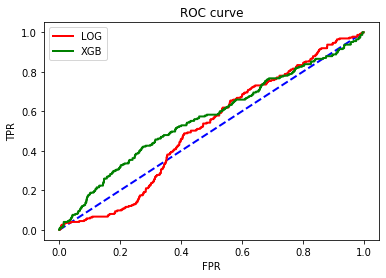

In [47]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

##calculate false positive and true positive rates
fpr, tpr,_=roc_curve(y_test,pd.DataFrame(y_pred_model_log)[1],drop_intermediate=False)
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb)[1],drop_intermediate=False)



# plot ROC and reference
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='red', lw=2, label='LOG')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='XGB')

##Title and label

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_ROCcurve.png')
plt.show()

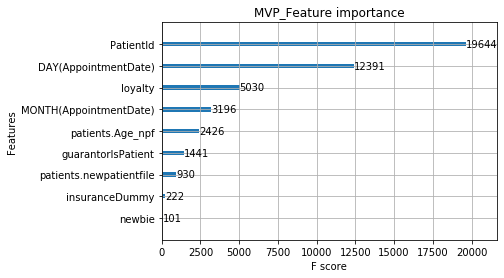

In [48]:
fig, ax = plt.subplots()
plot_importance(model_xgb, ax=ax)
plt.title('MVP_Feature importance')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_Feature_importance.png')
plt.show()

In [50]:
import pickle
#pickle model, code from Lindsay
# My model is called 'rf' (as you see above)- whatever you called your model, substitute that in for 'rf', below.
# Don't change anything else unless you really want to.
with open('insightMVP_model.pkl', 'wb') as fid:
    pickle.dump(model_xgb, fid,2)  


In [51]:

# Load the model from disk
loaded_model = pickle.load(open('insightMVP_model.pkl', 'rb'))



y_pred_model_xgb = loaded_model.predict_proba(X_test)

print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))

The AUC score of the XGB model is: 0.57
